In [ ]:
#!pip install pyspark

In [ ]:
import sys
import os
import os.path

from pyspark.ml.feature import VectorAssembler
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext("local")
spark = SparkSession(sc)

In [5]:


train_sd = spark.read.csv(path='trainst1ns16.csv', header=True, inferSchema=True)
test_sd = spark.read.csv(path='testst1ns16.csv', header=True, inferSchema=True)

validation_sd = train_sd.filter(train_sd['counter']>=10*365)
train_sd = train_sd.filter(train_sd['counter']<10*365)

train_sd = train_sd.drop('counter')
validation_sd = validation_sd.drop('counter')
test_sd = test_sd.drop('counter')

#Prepare de data
ignore = ['energy']

assembler1 = VectorAssembler(
    inputCols=[x for x in train_sd.columns if x not in ignore],
    outputCol='features')
train_sd = assembler1.transform(train_sd).select(['energy', 'features'])

assembler2 = VectorAssembler(
    inputCols=[x for x in validation_sd.columns if x not in ignore],
    outputCol='features')
validation_sd = assembler2.transform(validation_sd).select(['energy', 'features'])

assembler3 = VectorAssembler(
    inputCols=[x for x in test_sd.columns if x not in ignore],
    outputCol='features')
test_sd = assembler3.transform(test_sd).select(['energy', 'features'])


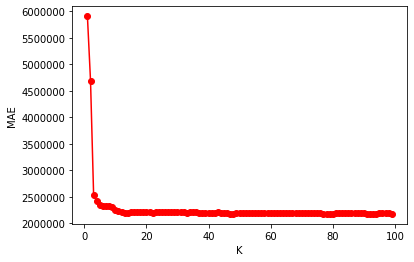

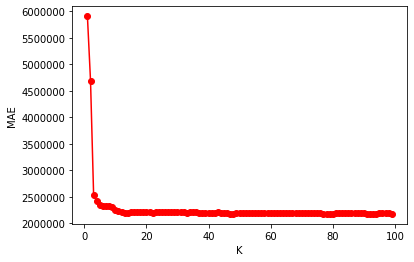

In [6]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

ks = []
maes=[]
 
for i in range(1,100):
  
    scaler1 = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=False, withMean=True)

    pca1 = PCA(k=i, inputCol="scaledFeatures")

    dt1 = LinearRegression(featuresCol=pca1.getOutputCol(),labelCol="energy")

    pipeline1 = Pipeline(stages=[scaler1, pca1, dt1])

    #Train the models
    model1 = pipeline1.fit(train_sd)

    evaluator = RegressionEvaluator(labelCol="energy", predictionCol="prediction", metricName="mae")

    predictions1 = model1.transform(validation_sd)

    mae = evaluator.evaluate(predictions1)
    ks.append(i)
    maes.append(mae)

fig = plt.figure()  
plt.plot(ks, maes,'-ok', color='r')  
plt.xlabel("K")
plt.ylabel("MAE")
plt.show()  
display(fig)

In [3]:
minpos = maes.index(min(maes)) 
maxpos = maes.index(max(maes))  
print("lower MAE: K = "+str(minpos+1)+", "+str(min(maes)))
print("higher MAE: K = "+str(maxpos+1)+", "+str(max(maes)))

lower MAE: K = 92, 2174491.5386627107
higher MAE: K = 1, 5908416.6622508615

In [4]:
ks = []
maes=[]
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
 
for i in range(90,101):
  
    scaler1 = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=False, withMean=True)

    pca1 = PCA(k=i, inputCol="scaledFeatures")

    dt1 = LinearRegression(featuresCol=pca1.getOutputCol(),labelCol="energy")

    pipeline1 = Pipeline(stages=[scaler1, pca1, dt1])

    #Train the models
    model1 = pipeline1.fit(train_sd)

    evaluator = RegressionEvaluator(labelCol="energy", predictionCol="prediction", metricName="mae")

    predictions1 = model1.transform(validation_sd)

    mae = evaluator.evaluate(predictions1)
    ks.append(i)
    maes.append(mae)

fig = plt.figure()  
plt.plot(ks, maes,'-ok', color='r')  
plt.xlabel("K")
plt.ylabel("MAE")
plt.show()  
display(fig)

In [7]:
minpos = maes.index(min(maes)) 
maxpos = maes.index(max(maes))  
print("lower MAE: K = "+str(minpos+90)+", "+str(min(maes)))
print("higher MAE: K = "+str(maxpos+90)+", "+str(max(maes)))

lower MAE: K = 181, 2174491.5386625496
higher MAE: K = 90, 5908416.662250863


In [9]:
## Part 2

train_sd = spark.read.csv(path='trainst1ns16.csv', header=True, inferSchema=True)
test_sd = spark.read.csv(path='testst1ns16.csv', header=True, inferSchema=True)


train_validation_sd = train_sd.filter(train_sd['counter']>=0)

train_validation_sd = train_sd.drop('counter')
test_sd = test_sd.drop('counter')

ignore = ['energy']

assembler1_2 = VectorAssembler(
    inputCols=[x for x in train_validation_sd.columns if x not in ignore],
    outputCol='features')
train_validation_sd = assembler1_2.transform(train_validation_sd).select(['energy', 'features'])

assembler2_2 = VectorAssembler(
    inputCols=[x for x in test_sd.columns if x not in ignore],
    outputCol='features')
test_sd = assembler3.transform(test_sd).select(['energy', 'features'])

ks = []
maes=[]

scaler1 = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=False, withMean=True)

pca1 = PCA(k=1200, inputCol="scaledFeatures")

dt1 = LinearRegression(featuresCol=pca1.getOutputCol(),labelCol="energy")

pipeline1 = Pipeline(stages=[scaler1, pca1, dt1])

model1 = pipeline1.fit(train_validation_sd)

evaluator = RegressionEvaluator(labelCol="energy", predictionCol="prediction", metricName="mae")

predictions1 = model1.transform(test_sd)

mae = evaluator.evaluate(predictions1)
ks.append(1200)
maes.append(mae)


In [10]:
print("MAE with K = 1200 : " +str(max(maes)))

MAE with K = 1200 : 2669224.605897426


# Conclusion

After this, we can see that with 1200 PCAs we obtain a MAE equal to 2669224.608 which is more or less the same MAE as with 3 PCAs but greater than the MAE obtained 92, which was 2174491.5386627945. Analysing that, we can say that there is a large amount of redundancy in the input attributes that can be eliminated through PCA because only with 3 PCAs can we obtain the same MAE as with the original number of attributes. In order to obtain the highest accuracy we will only need 92 PCAs instead of the 1200 attributes of the data set.